In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools
import numpy as np
from random import seed

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

I have gathered a dataset from citydata. Over the course of several days I respectfully scraped information about each county in the United States, creating the following data set:

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/cabriggs/house-appreciation/main/df_citydata.csv')

In [3]:
df.head()

,fips,state,county,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_2000,median_age,median_age_f,...,births_to_yr_int2,pop_foreign_born,land_area_km2,land_area_mi2,water_area_km2,water_area_mi2,total_area_km2,total_area_mi2,latitude,longitude
0,1001,AL,Autauga,55308.0,2017,28306.0,27002.0,43671.0,38.0,39.2,...,2006.0,1170.0,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536382,-86.644490
1,1003,AL,Baldwin,212628.0,2017,107930.0,104698.0,140415.0,42.6,44.3,...,2006.0,10881.0,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,30.659218,-87.746067
2,1005,AL,Barbour,26330.0,2017,12301.0,14029.0,29038.0,39.9,43.3,...,2006.0,701.0,2291.819,884.876,50.865,19.639,2342.684,904.515,31.870670,-85.405456
3,1007,AL,Bibb,22691.0,2017,10393.0,12298.0,20826.0,40.0,43.6,...,2006.0,232.0,1612.481,622.582,9.289,3.587,1621.770,626.169,33.015893,-87.127148
4,1009,AL,Blount,57952.0,2017,29352.0,28600.0,51024.0,41.1,42.6,...,2006.0,2638.0,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977448,-86.567246


Here are the column names. Most of the names should be self explanatory. Please see the accompanying data dictionary for an explanation of each variable.

In [4]:
df.columns

Index(['fips', 'state', 'county', 'pop_in_later_year', 'pop_ref_later_year',
       'pop_f', 'pop_m', 'pop_in_2000', 'median_age', 'median_age_f',
       'median_age_m', 'median_house_income_2017',
       'median_house_income_ref_val', 'median_house_income_ref_yr',
       'median_house_value_2017', 'median_house_value_2000',
       'avg_household_size', 'mar_coup_w_children', 'cost_of_living_usd',
       'cost_of_living_yr', 'poverty_pct', 'adult_obes_rate',
       'presch_obes_rate', 'commute_minutes', 'pop_per_sq_mi',
       'pop_percent_urban', 'unemploy_rate', 'unemploy_date', 'rent_1br_usd',
       'rent_2br_usd', 'rent_3br_usd', 'avg_farm_size', 'avg_farm_sales_usd',
       'pct_farms_fam_op', 'avg_farm_mach_val_usd', 'birth_per_1000_int1',
       'births_from_yr_int1', 'births_from_yr_int2', 'birth_per_1000_int2',
       'births_to_yr_int1', 'births_to_yr_int2', 'pop_foreign_born',
       'land_area_km2', 'land_area_mi2', 'water_area_km2', 'water_area_mi2',
       'total_area_km

The target variable is presch_obes_rate: preschool obesity rate. Rows without a value for the target variable will not be useful for us, so I will drop those.

In [5]:
df = df[df.presch_obes_rate==df.presch_obes_rate]

In [6]:
len(df)

2692

We still have about 2700 observations remaining. Let's examine the target variable.

Text(0.5, 1.0, 'Histogram of preschool obesity rates by US county')

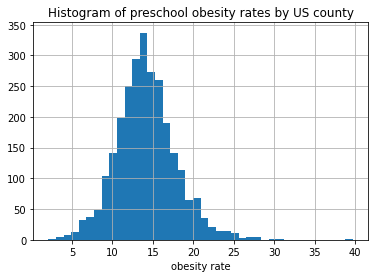

In [7]:
df['presch_obes_rate'].hist(bins=40)
plt.xlabel('obesity rate')
plt.title('Histogram of preschool obesity rates by US county')

In [8]:
df['presch_obes_rate'].describe()

count    2692.000000
mean       14.198588
std         3.723109
min         2.100000
25%        11.900000
50%        14.000000
75%        16.300000
max        39.700000
Name: presch_obes_rate, dtype: float64

For comparison, we can look at the histogram of the adult obesity rate. It is also reasonable to expect that preschool obesity would be predicted by adult obesity (refs).

Text(0.5, 1.0, 'Histogram of adult obesity rates by US county')

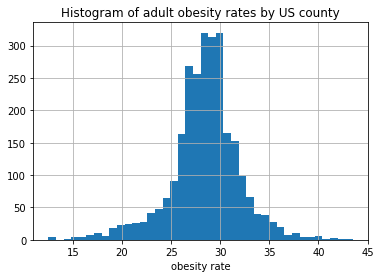

In [9]:
df['adult_obes_rate'].hist(bins=40)
plt.xlabel('obesity rate')
plt.title('Histogram of adult obesity rates by US county')

In [10]:
df['adult_obes_rate'].describe()

count    2692.000000
mean       28.444094
std         3.563973
min        12.500000
25%        26.800000
50%        28.600000
75%        30.300000
max        43.500000
Name: adult_obes_rate, dtype: float64

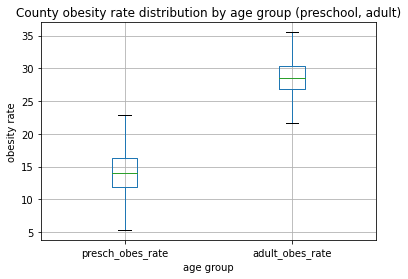

In [11]:
# give vertical bar plots with standard deviation etc, child & adult obesity

df.boxplot(column=['presch_obes_rate', 'adult_obes_rate'], showfliers=False)
plt.xlabel('age group')
plt.ylabel('obesity rate')
plt.title('County obesity rate distribution by age group (preschool, adult)')
plt.show()

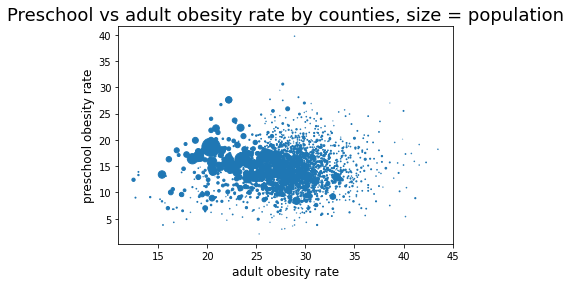

In [12]:
plt.scatter(x=df.adult_obes_rate,y=df.presch_obes_rate, s=df.pop_in_later_year/30000)
plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('adult obesity rate',fontsize=12)
plt.ylabel('preschool obesity rate',fontsize=12)
plt.title('Preschool vs adult obesity rate by counties, size = population',fontsize=18)
plt.show()

To get a better view of the data points, I will manually set x and y limits. Note that the axes will no longer begin at 0.

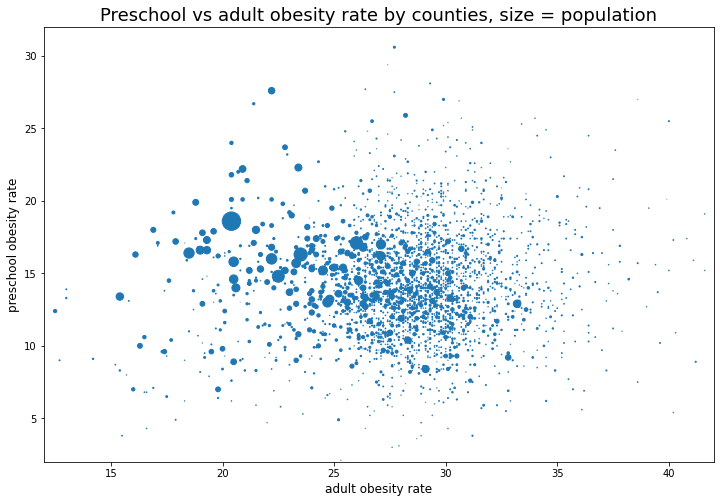

In [13]:
plt.scatter(x=df.adult_obes_rate,y=df.presch_obes_rate, s=df.pop_in_later_year/30000)
plt.rcParams["figure.figsize"] = (12,8)
plt.xlim(12, 42)
plt.ylim(2, 32)
plt.xlabel('adult obesity rate',fontsize=12)
plt.ylabel('preschool obesity rate',fontsize=12)
plt.title('Preschool vs adult obesity rate by counties, size = population',fontsize=18)
plt.show()

The larger counties (probably home to large cities) appear to be  more tightly clustered than counties in general. We see adult obesity between about 15 and 30%, and preschool obesity between 10 and 20%. The smaller counties are more spread out. Interestingly, from visual inspection, the smaller counties appear to have lower preschool obesity and markedly higher adult obesity. The fact that the largest counties occupying a middle range of the target variable is an early clue that nonlinear models will be more effective for this data set.

Let's have one more look at this plot, overlaying means for huge, large, and small counties. I'll define a huge county as among the top 10 in population size, a large city as at least one standard deviation above the mean, and small counties as those smaller than the mean.

In [14]:
small_pop_cutoff = df.pop_in_later_year.describe()['mean']
big_pop_cutoff = df.pop_in_later_year.describe()['mean']+df.pop_in_later_year.describe()['std']
huge_pop_cutoff = df.pop_in_later_year.nlargest(10).min()

small_pop_adult_obes = df[df.pop_in_later_year<=small_pop_cutoff].adult_obes_rate.describe()['mean']
small_pop_presch_obes = df[df.pop_in_later_year<=small_pop_cutoff].presch_obes_rate.describe()['mean']
big_pop_adult_obes = df[df.pop_in_later_year>=big_pop_cutoff].adult_obes_rate.describe()['mean']
big_pop_presch_obes = df[df.pop_in_later_year>=big_pop_cutoff].presch_obes_rate.describe()['mean']
huge_pop_adult_obes = df[df.pop_in_later_year>huge_pop_cutoff].adult_obes_rate.describe()['mean']
huge_pop_presch_obes = df[df.pop_in_later_year>huge_pop_cutoff].presch_obes_rate.describe()['mean']

In [15]:
print(huge_pop_adult_obes,huge_pop_presch_obes)
print(big_pop_adult_obes,big_pop_presch_obes)
print(small_pop_adult_obes,small_pop_presch_obes)

22.82222222222222 16.11111111111111
24.546153846153846 14.92167832167832
28.965629290617848 14.205766590389015


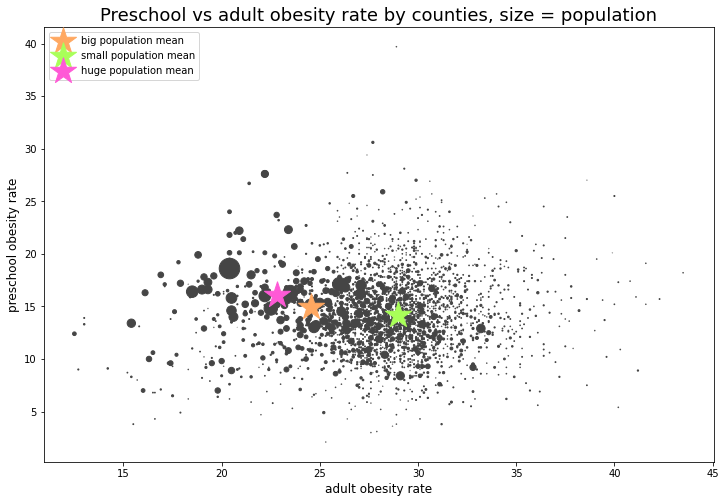

In [16]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)

ax1.scatter(x=df.adult_obes_rate,y=df.presch_obes_rate, c='#454545',s=df.pop_in_later_year/24000)
ax1.scatter(big_pop_adult_obes,big_pop_presch_obes, s=750, c='#ffa861', marker="*", label='big population mean')
ax1.scatter(small_pop_adult_obes,small_pop_presch_obes, s=750, c='#a9ff59', marker="*", label='small population mean')
ax1.scatter(huge_pop_adult_obes,huge_pop_presch_obes, s=750, c='#ff59d6', marker="*", label='huge population mean')
plt.xlabel('adult obesity rate',fontsize=12)
plt.ylabel('preschool obesity rate',fontsize=12)
plt.title('Preschool vs adult obesity rate by counties, size = population',fontsize=18)
plt.legend(loc='upper left');
plt.show()

This plot shows that we cannot rely on adult (or overall) obesity rates to identify counties which may be experiencing elevated preschool obesity rates. Preschool obesity must be treated as a problem independent of adult obesity.

I'll derive some new variables that I think may be relevant to the models. For example, using the population in the reference year (2000) and population in the later year (between 2005 and 2017), I will compute the average population percentage growth between the two years.

In [17]:
df['pop_growth_rate']=(df.pop_in_later_year-df.pop_in_2000)**(1/(df.pop_ref_later_year-2000))

I'll also derive the following variables:

- pop_density: population density (population over land area)
- urban_pop_density: urban population density (urban population over land area)
- gender_age_gap: median age difference between males and females
- income_growth_rate: average annual percentage change in household income
- married_with_kids_ratio: the fraction of the population consisting of married couples with children
- adult_obes_per_pov: the adult obesity rate over the poverty rate
- commute_over_sqrt_area: the commute time over the square root of the land area
- apartment_rent_ratio: the cost of a 3 bedroom apartment divided by the cost of a 1 bedroom apartment
- birth_rate_change: the change in birthrate from the 1990-2000 period to the 2000-2006 period, and
- foreign_born_pct: the foreign born population as a percentage of the total population.

In [18]:
df['pop_density']=df.pop_in_later_year/df.land_area_mi2
df['urban_pop_density']=df.pop_density*df.pop_percent_urban
df['gender_age_gap']=df.median_age_m - df.median_age_f
df['income_growth_rate']=(df.median_house_income_2017-df.median_house_income_ref_val)**\
                      (1/(2017-df.median_house_income_ref_yr))
df['adult_obes_per_pov'] = df.adult_obes_rate/df.poverty_pct
df['married_with_kids_ratio']=df.mar_coup_w_children*2/df.pop_in_later_year
df['commute_over_sqrt_area']=df.commute_minutes/np.sqrt(df.land_area_mi2)
df['apartment_rent_ratio']=df.rent_3br_usd/df.rent_1br_usd
df['birth_rate_change']=df.birth_per_1000_int2 - df.birth_per_1000_int1
df['foreign_born_pct'] = df.pop_foreign_born/df.pop_in_later_year

I'll check the correlation matrix for interesting variables. I'll drop the columns not otherwise in use, then drop the rows with missing values.

In [19]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/lillian/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2742: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/lillian/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2743: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,fips,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_2000,median_age,median_age_f,median_age_m,median_house_income_2017,median_house_income_ref_val,median_house_income_ref_yr,median_house_value_2017,median_house_value_2000,avg_household_size,mar_coup_w_children,cost_of_living_usd,cost_of_living_yr,poverty_pct,adult_obes_rate,presch_obes_rate,commute_minutes,pop_per_sq_mi,pop_percent_urban,unemploy_rate,unemploy_date,rent_1br_usd,rent_2br_usd,rent_3br_usd,avg_farm_size,avg_farm_sales_usd,pct_farms_fam_op,avg_farm_mach_val_usd,birth_per_1000_int1,births_from_yr_int1,births_from_yr_int2,birth_per_1000_int2,births_to_yr_int1,births_to_yr_int2,pop_foreign_born,land_area_km2,land_area_mi2,water_area_km2,water_area_mi2,total_area_km2,total_area_mi2,latitude,longitude,pop_growth_rate,pop_density,urban_pop_density,gender_age_gap,income_growth_rate,adult_obes_per_pov,married_with_kids_ratio,commute_over_sqrt_area,apartment_rent_ratio,birth_rate_change,foreign_born_pct
fips,1.000000,-0.048254,-0.176649,-0.047973,-0.048534,-0.047108,0.044803,0.032050,0.051746,0.070672,0.007282,-0.002043,-0.006820,-0.035925,-0.018769,-0.041252,0.037048,nan,-0.070879,0.020757,0.076420,0.015208,0.028915,0.001912,-0.047174,-0.002095,-0.001812,-0.006196,-0.012191,0.056675,-0.145343,0.096744,-0.110715,-0.085643,nan,nan,-0.085414,nan,nan,-0.054386,-0.071664,-0.071664,-0.004459,-0.004459,-0.070941,-0.070941,0.155477,0.123839,-0.054024,0.038135,0.036609,0.052458,0.135588,0.076154,-0.009224,0.123819,-0.007150,-0.004362,0.000808
pop_in_later_year,-0.048254,1.000000,0.208955,0.999887,0.999879,0.989851,-0.177714,-0.179987,-0.175303,0.286840,0.313536,0.017603,0.404930,0.379090,0.050236,0.988235,0.409340,nan,-0.094154,-0.249513,0.048470,0.114874,0.332598,0.400842,-0.081107,0.017802,0.460049,0.462993,0.460417,-0.072390,0.057035,-0.244016,-0.078489,0.229463,nan,nan,0.180110,nan,nan,0.925731,0.141069,0.141069,0.129863,0.129863,0.158281,0.158281,-0.048957,-0.038643,0.509496,0.212320,0.213146,0.016971,0.143203,0.008349,0.040639,0.040188,-0.020807,-0.092101,0.498836
pop_ref_later_year,-0.176649,0.208955,1.000000,0.209568,0.208270,0.200100,-0.105659,-0.122616,-0.133364,0.106297,0.198061,-0.167052,0.164584,0.226785,-0.084861,0.215922,0.225816,nan,0.034642,-0.048822,-0.025140,0.109145,0.092173,0.294891,0.024592,-0.167177,0.243921,0.228856,0.229906,-0.136594,-0.010701,-0.044744,-0.075348,0.157996,nan,nan,0.116652,nan,nan,0.122238,0.002162,0.002162,0.030839,0.030839,0.006866,0.006866,-0.118007,0.070239,0.324881,0.058351,0.058592,-0.026105,-0.085952,-0.041267,-0.098792,0.037646,-0.063082,-0.079092,0.149939
pop_f,-0.047973,0.999887,0.209568,1.000000,0.999533,0.990568,-0.176964,-0.179316,-0.174635,0.285851,0.313115,0.018502,0.404363,0.378849,0.048448,0.987131,0.410550,nan,-0.093217,-0.248906,0.048407,0.115792,0.338959,0.401815,-0.081713,0.018708,0.460859,0.463478,0.460059,-0.072930,0.055653,-0.246140,-0.079361,0.228996,nan,nan,0.179670,nan,nan,0.925208,0.138054,0.138054,0.129615,0.129615,0.155287,0.155287,-0.049213,-0.034855,0.509874,0.215096,0.215940,0.016946,0.141944,0.007526,0.039160,0.043019,-0.023485,-0.092071,0.499066
pop_m,-0.048534,0.999879,0.208270,0.999533,1.000000,0.988872,-0.178449,-0.180640,-0.175954,0.287797,0.313898,0.016668,0.405421,0.379249,0.052077,0.989145,0.407988,nan,-0.095102,-0.250082,0.048524,0.113896,0.325930,0.399738,-0.080461,0.016861,0.459101,0.462380,0.460679,-0.071819,0.058451,-0.241760,-0.077572,0.229893,nan,nan,0.180524,nan,nan,0.926053,0.144159,0.144159,0.130089,0.130089,0.161345,0.161345,-0.048681,-0.042558,0.508988,0.209394,0.210201,0.016993,0.144474,0.009199,0.042160,0.037246,-0.018029,-0.092111,0.498478
pop_in_2000,-0.047108,0.989851,0.200100,0.990568,0.988872,1.000000,-0.163501,-0.163973,-0.163268,0.266291,0.293582,0.016132,0.391001,0.369892,0.034469,0.966536,0.405228,nan,-0.082206,-0.235004,0.044439,0.108337,0.344428,0.385145,-0.071360,0.016336,0.447758,0.451450,0.444312,-0.071576,0.051612,-0.247920,-0.071407,0.213365,nan,nan,0.157368,n

In [20]:
smallest_corr = corr['presch_obes_rate'].min()
largest_corr = corr['presch_obes_rate'].nlargest(2).min()
print(f'The correlations range from {round(smallest_corr,3)} to {round(largest_corr,3)}.')

The correlations range from -0.109 to 0.198.


The small correlations are surprising. For contrast, 27 of the 52 numeric variables have a correlation with adult obesity rate greater in magnitude than 0.2.

In [21]:
presch_obes_high_corr = [(round(y,3),x) for (x,y) in zip(corr['presch_obes_rate'].keys(),corr['presch_obes_rate'].values) if abs(y)>0 and y<1]
presch_obes_high_corr.sort()
print(' corr      variable')
print(' ----      --------')
for pair in sorted(presch_obes_high_corr,key=lambda x: abs(x[0]),reverse=True)[:20]:
    if pair[0]>0: print(f'{(len(str(pair[0]))-4)*" "}{pair[0]:5}{(9-len(str(pair[0])))*" "}{pair[1]:35}')
    else: print(f'{pair[0]:4}{(10-len(str(pair[0])))*" "}{pair[1]:40}')


 corr      variable
 ----      --------
 0.198    commute_over_sqrt_area             
 0.175    foreign_born_pct                   
 0.12     birth_per_1000_int2                
 0.114    longitude                          
-0.109    land_area_km2                           
-0.109    land_area_mi2                           
-0.105    total_area_km2                          
-0.105    total_area_mi2                          
 0.105    poverty_pct                        
-0.095    apartment_rent_ratio                    
 0.089    birth_per_1000_int1                
 0.086    adult_obes_rate                    
-0.085    latitude                                
 0.085    rent_1br_usd                       
 0.081    avg_household_size                 
 0.081    commute_minutes                    
 0.081    cost_of_living_usd                 
 0.079    pop_density                        
 0.078    urban_pop_density                  
 0.076    fips                               


In [22]:
adult_obes_high_corr = [(round(y,3),x) for (x,y) in zip(corr['adult_obes_rate'].keys(),corr['adult_obes_rate'].values) if abs(y)>0.2 and y<1]
adult_obes_high_corr.sort()
print(' corr      variable')
print(' ----      --------')
for pair in sorted(adult_obes_high_corr,key=lambda x: abs(x[0]),reverse=True)[:20]:
    if pair[0]>0: print(f'{pair[0]:6}{(9-len(str(pair[0])))*" "}{pair[1]:35}')
    else: print(f'{pair[0]:4}{(10-len(str(pair[0])))*" "}{pair[1]:40}')


 corr      variable
 ----      --------
-0.602    median_house_value_2017                 
-0.57     median_house_value_2000                 
-0.529    rent_3br_usd                            
-0.52     median_house_income_2017                
-0.506    rent_2br_usd                            
 0.485    poverty_pct                        
-0.469    median_house_income_ref_val             
-0.464    rent_1br_usd                            
-0.43     cost_of_living_usd                      
-0.423    income_growth_rate                      
-0.414    foreign_born_pct                        
-0.336    pop_growth_rate                         
-0.313    pop_percent_urban                       
 0.262    longitude                          
-0.258    mar_coup_w_children                     
 0.256    pct_farms_fam_op                   
-0.254    married_with_kids_ratio                 
-0.25     pop_in_later_year                       
-0.25     pop_m                                   
-0.249

I drop the columns with non-numeric values or numeric values irrelevant to the model (e.g. years in which measurements were taken).

In [23]:
df_num = df.select_dtypes([np.number])
df_num = df_num.drop(['fips','pop_ref_later_year',
             'median_house_income_ref_yr',
             'cost_of_living_yr',
             'unemploy_date',
             'births_from_yr_int1',
             'births_from_yr_int2',
             'births_to_yr_int1',
             'births_to_yr_int2'],axis = 1)
df_num = df_num.dropna()

In [24]:
# Split the dataset into train, validation, and test sets
# set the random seed
seed(1274)

# separate out the features and target
X = df_num.iloc[:,df_num.columns != 'presch_obes_rate']
y = df_num.iloc[:,df_num.columns=='presch_obes_rate']

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)
y_train = StandardScaler().fit_transform(y_train)
y_val = StandardScaler().fit_transform(y_val)
y_test = StandardScaler().fit_transform(y_test)

I'll fit a variety of models to the training data, then test them on the validation data. I will take the best model and check on on the test data. I will skip the linear model, as the exploratory data analysis gives us some indication that the best model will not be linear. Some of the following code can also be found in my [housing prices project](https://github.com/cabriggs/house-appreciation).

Text(0.5, 1.0, 'PCA: features remaining vs variance retained')

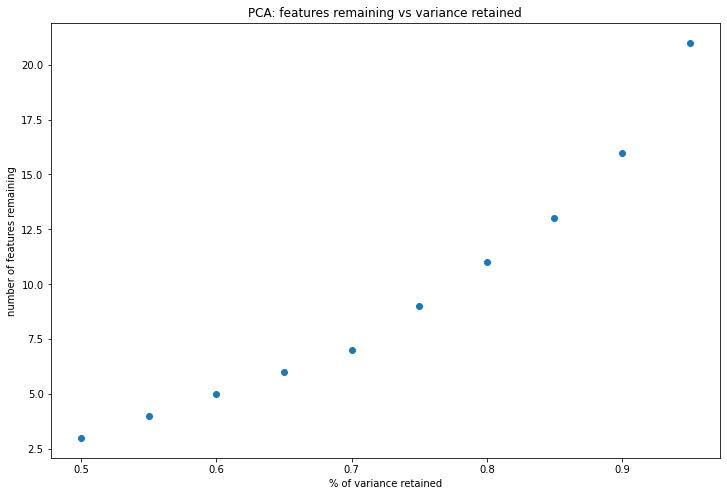

In [25]:
seed(1274)

xs = np.linspace(0.50,0.95,10)
ys = []
for i in xs:
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    ys.append(X_train_pca.shape[1])
plt.scatter(xs, ys)
plt.xlabel('% of variance retained')
plt.ylabel('number of features remaining')
plt.title('PCA: features remaining vs variance retained')

In [26]:
# A dictionary to store the accuracy of each model
accuracy = []

In [27]:
# Trying linear regression. I use PCA to reduce the features.
pca = PCA(n_components=0.65, whiten = True)
X_train_pca = pca.fit_transform(X_train)
ols = LinearRegression()
ols.fit(X_train_pca, y_train)
lin_accuracy = ols.score(pca.fit_transform(X_val), y_val)
print("Linear regression model R^2: {}".format(round(lin_accuracy,3)))
accuracy.append((lin_accuracy,'linear regression',ols))

Linear regression model R^2: 0.002


In [28]:
# Now trying a random forest prediction. First, feature reduction for RF
randomforest = RandomForestRegressor(random_state=1274, n_jobs=-1)
selector = SelectFromModel(randomforest, threshold = 0.001)
X_train_rf = selector.fit_transform(X_train, y_train.ravel())

In [29]:
# train the random forest model
model_rf = randomforest.fit(X_train_rf, y_train.ravel())

# pare X_val to the features used in the rf model
X_val_rf = pd.DataFrame(X_val).iloc[:,selector.get_support()]

# report accuracy
rf_accuracy = model_rf.score(X_val_rf,y_val)
print("Random forest model R^2: {}".format(round(rf_accuracy,3)))
accuracy.append((rf_accuracy,'random forest',model_rf))

Random forest model R^2: 0.239


In [30]:
''' Use GridSearch to discover the best parameters in a predefined range. Given more machine power/time/benefit
    for optimized results, I would expand the search space.
'''
gsc = GridSearchCV(
        estimator=MLPRegressor(),
        param_grid={
            'max_iter': [400,600,800],
            'hidden_layer_sizes': [(30,30),(40,40),(40,30),(40,40)]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train.ravel())

best_params = grid_result.best_params_

# define the regressor and set parameters
mlp = MLPRegressor(hidden_layer_sizes = best_params['hidden_layer_sizes'], max_iter = best_params['max_iter'])

# fit the model
mlp.fit(X_train,y_train.ravel())

mlp_accuracy = mlp.score(X_val,y_val)

print("Neural network R^2: {}".format(round(mlp_accuracy,3)))
accuracy.append((mlp_accuracy,'neural network',mlp))

Neural network R^2: 0.192


In [31]:
# Trying a support vector regressor
svr = SVR()
svr.fit(X_train,y_train.ravel())
svr_accuracy = svr.score(X_val,y_val)
print("Support vector regressor R^2: {}".format(round(svr_accuracy,3)))
accuracy.append((svr_accuracy,'support vector',svr))

Support vector regressor R^2: 0.186


In [32]:
# Trying XGBoost regressor
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
xgb_accuracy = xgb.score(X_val,y_val)
print("XGBoost regressor R^2: {}".format(round(xgb_accuracy,3)))
accuracy.append((xgb_accuracy,'xgb',xgb))

XGBoost regressor R^2: 0.075


Max decision tree bagging accuracy at 80 estimators.
Decision tree bagging accuracy: 0.258


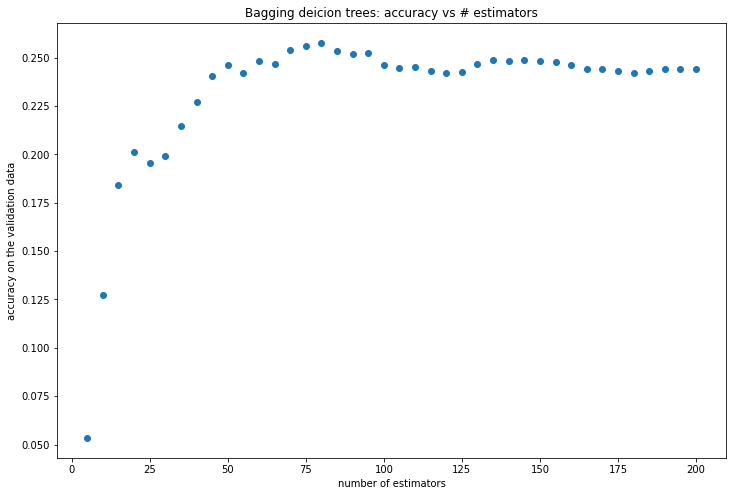

In [33]:
# Bagging with decision trees

# Optimizing the number of regresors
x_dct = [5*i for i in range(1,41)]
y_dct = []
for i in x_dct:
    br = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_dct.append(br.score(X_val,y_val))
plt.scatter(x_dct,y_dct)
plt.xlabel('number of estimators')
plt.ylabel('accuracy on the validation data')
plt.title('Bagging deicion trees: accuracy vs # estimators')

# Training with the optimum number of regressors
dt_max_num = x_dct[y_dct.index(max(y_dct))]
print('Max decision tree bagging accuracy at {} estimators.'.format(dt_max_num))
br_dt = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=dt_max_num, random_state=0)
br_dt.fit(X_train,y_train.ravel())
dt_bag_score = br_dt.score(X_val,y_val)
print('Decision tree bagging accuracy: {}'.format(round(dt_bag_score,3)))
accuracy.append((dt_bag_score,'bagging: decision tree',br_dt))

/home/lillian/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lillian/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lillian/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Max NN bagging accuracy at 35 estimators.
NN bagging accuracy: 0.247


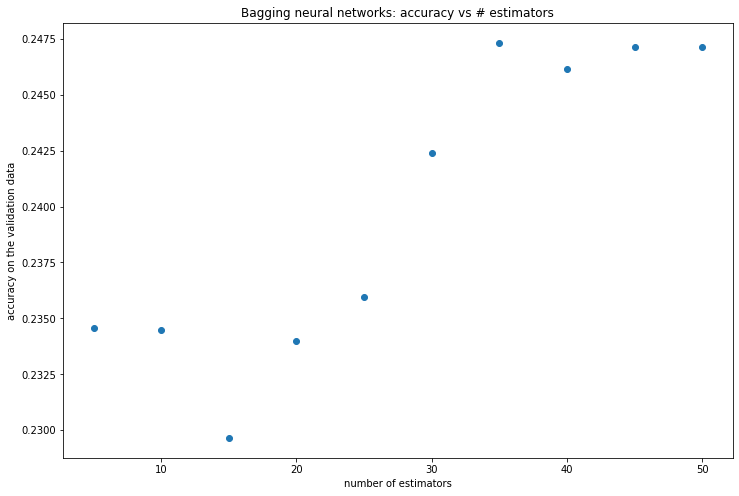

In [34]:
# Bagging with neural networks

# Optimizing the number of regresors
x_mlp = [5*i for i in range(1,11)]
y_mlp = []
for i in x_mlp:
    br = BaggingRegressor(base_estimator=MLPRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_mlp.append(br.score(X_val,y_val))
plt.scatter(x_mlp,y_mlp)
plt.xlabel('number of estimators')
plt.ylabel('accuracy on the validation data')
plt.title('Bagging neural networks: accuracy vs # estimators')

# Training with the optimum number of regressors
nn_max_num = x_dct[y_mlp.index(max(y_mlp))]
print('Max NN bagging accuracy at {} estimators.'.format(nn_max_num))
br_nn = BaggingRegressor(base_estimator=MLPRegressor(),n_estimators=nn_max_num, random_state=0)
br_nn.fit(X_train,y_train.ravel())
nn_bag_score = br_nn.score(X_val,y_val)
print('NN bagging accuracy: {}'.format(round(nn_bag_score,3)))
accuracy.append((nn_bag_score,'bagging: neural network',br_nn))

Max XGB bagging accuracy at 150 estimators.
Bagged decision tree accuracy: 0.243


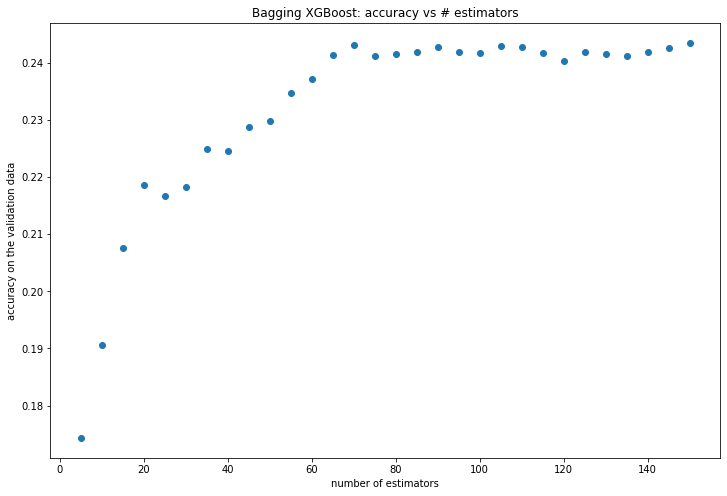

In [35]:
# Bagging with XGBoost

# Optimizing the number of regresors
x_xgb = [5*i for i in range(1,31)]
y_xgb = []
for i in x_xgb:
    br = BaggingRegressor(base_estimator=XGBRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_xgb.append(br.score(X_val,y_val))
plt.scatter(x_xgb,y_xgb)
plt.xlabel('number of estimators')
plt.ylabel('accuracy on the validation data')
plt.title('Bagging XGBoost: accuracy vs # estimators')

# Training with the optimum number of regressors
xgb_max_num = x_xgb[y_xgb.index(max(y_xgb))]
print('Max XGB bagging accuracy at {} estimators.'.format(xgb_max_num))
br_xgb = BaggingRegressor(base_estimator=XGBRegressor(),n_estimators=xgb_max_num, random_state=0)
br_xgb.fit(X_train,y_train.ravel())
xgb_bag_score = br_xgb.score(X_val,y_val)
print('Bagged decision tree accuracy: {}'.format(round(xgb_bag_score,3)))
accuracy.append((xgb_bag_score,'bagging: xgb',br_xgb))

Max SVR bagging accuracy at 140 estimators.
Bagged decision tree accuracy: 0.189


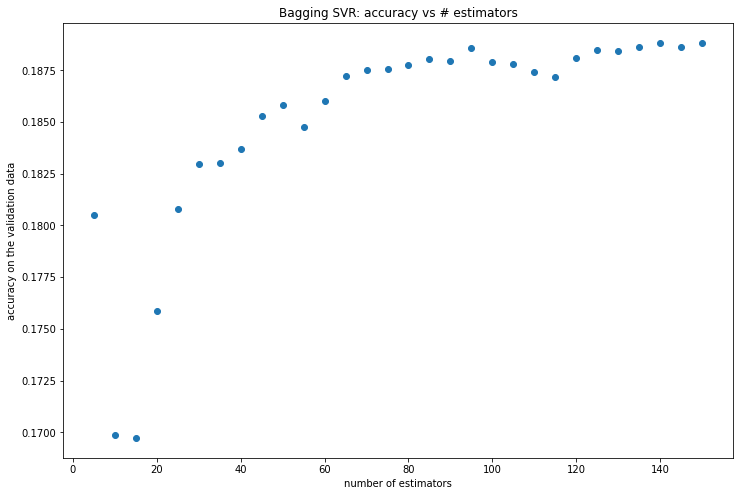

In [36]:
# Bagging with support vector regressors

# Optimizing the number of regresors
x_svr = [5*i for i in range(1,31)]
y_svr = []
for i in x_svr:
    br = BaggingRegressor(base_estimator=SVR(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_svr.append(br.score(X_val,y_val))
plt.scatter(x_svr,y_svr)
plt.xlabel('number of estimators')
plt.ylabel('accuracy on the validation data')
plt.title('Bagging SVR: accuracy vs # estimators')

# Training with the optimum number of regressors
svr_max_num = x_svr[y_svr.index(max(y_svr))]
print('Max SVR bagging accuracy at {} estimators.'.format(svr_max_num))
br_svr = BaggingRegressor(base_estimator=SVR(),n_estimators=svr_max_num, random_state=0)
br_svr.fit(X_train,y_train.ravel())
svr_bag_score = br_svr.score(X_val,y_val)
print('Bagged decision tree accuracy: {}'.format(round(svr_bag_score,3)))
accuracy.append((svr_bag_score,'bagging: svr',br_svr))

Let's review the models by accuracy.

In [37]:
accuracy.sort()
print('Accuracy    Model')
print('-'*8,' '*2,'-'*17)
for model in accuracy:
    print('   {}    {}'.format(round(model[0],3),model[1]))

Accuracy    Model
--------    -----------------
   0.002    linear regression
   0.075    xgb
   0.186    support vector
   0.189    bagging: svr
   0.192    neural network
   0.239    random forest
   0.243    bagging: xgb
   0.247    bagging: neural network
   0.258    bagging: decision tree


Bagging has significantly improved the predictive accuracy of the models. The most accurate model was the bagging decision tree. To check the model's accuracy on unseen data, we now run it on the yet-unseen test data set.

In [38]:
print('Best model: {}'.format(accuracy[-1][1]))
best_model = accuracy[-1][2]
best_accuracy = best_model.score(X_test,y_test)
print('Accuracy on test data: {}'.format(best_accuracy))

Best model: bagging: decision tree
Accuracy on test data: 0.14294380099227533


The best model does not explain much of the variation in preschool obesity rates between counties. I am surprised at how little is explained by the model, although perhaps less so because of how uncorrelated the target variable is to the any of the features.

For comparison, see how well the same type of model predicts adult obesity.

Max decision tree bagging accuracy at 195 estimators.
Decision tree bagging accuracy: 0.706


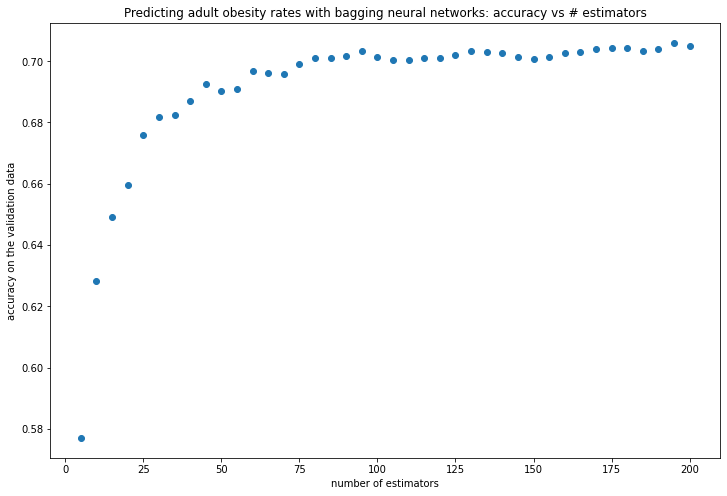

In [39]:
# Split the dataset into train, validation, and test sets
# set the random seed
seed(1274)

# separate out the features and target
X = df_num.iloc[:,df_num.columns != 'adult_obes_rate']
y = df_num.iloc[:,df_num.columns=='adult_obes_rate']

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)
y_train = StandardScaler().fit_transform(y_train)
y_val = StandardScaler().fit_transform(y_val)
y_test = StandardScaler().fit_transform(y_test)

# Bagging with decision trees

# Optimizing the number of regresors
x_dct = [5*i for i in range(1,41)]
y_dct = []
for i in x_dct:
    br = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_dct.append(br.score(X_val,y_val))
plt.scatter(x_dct,y_dct)
plt.xlabel('number of estimators')
plt.ylabel('accuracy on the validation data')
plt.title('Predicting adult obesity rates with bagging decision trees: accuracy vs # estimators')

# Training with the optimum number of regressors
dt_max_num = x_dct[y_dct.index(max(y_dct))]
print('Max decision tree bagging accuracy at {} estimators.'.format(dt_max_num))
br_dt = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=dt_max_num, random_state=0)
br_dt.fit(X_train,y_train.ravel())
dt_bag_score = br_dt.score(X_val,y_val)
print('Decision tree bagging accuracy: {}'.format(round(dt_bag_score,3)))
accuracy.append((dt_bag_score,'bagging: decision tree',br_dt))

In [40]:
adult_accuracy = br_dt.score(X_test,y_test)
print(f'The bagging decision tree model has accuracy on test data: {round(adult_accuracy,3)}.')

The bagging decision tree model has accuracy on test data: 0.686.


This is more in line with what I expected. I remain surprised at the extent to which preschool obesity is unpredictable at the county level. The positive outcome of this study is: unlike adult obesity rates, preschool obesity rates cannot be effectively predicted from county-level information such as has been gathered in the present data set. While efficient interventions target adult obesity at the county-level, preschool obesity should be targeted on a more individualized level. A future study should gather household information, and attempt to predict preschool obesity rates based on the household data. One potential route is to pair surveyed preschool obesity rates with long-form census data.

In [41]:
accuracy

[(0.0020514284547317185, 'linear regression', LinearRegression()),
 (0.07492357388515858,
  'xgb',
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)),
 (0.18629284160273762, 'support vector', SVR()),
 (0.18883670351708737,
  'bagging: svr',
  BaggingRegressor(base_estimator=SVR(), n_estimators=140, random_state=0)),
 (0.19159098027223587,
  'neural network',
  MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=600)),
 (0.23936241588657425,
  'random forest